# Plotting Source Sink Cross Validation Experiment

Acknowledgements: See https://github.com/sipv/MultipanelFigures/blob/main/MultipanelFigures.ipynb for a great explanation on laying out figures in matplotlib

In [1]:
%load_ext lab_black

In [89]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from sklearn.metrics import auc

import pingouin as pg
from mlxtend.evaluate import mcnemar_table, mcnemar
import dabest

import sys

sys.path.append("../../")
from episcalp.utils.standard_1020_montage import get_standard_1020_montage

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Options

In [3]:
# Set font sizes
SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [12]:
def load_participant_df(root, subject):
    """Load participants.tsv file as a dataframe for a specific subject.

    Note: subject ID needs to be in format ``sub-<subject>``.
    """
    df = pd.read_csv(os.path.join(root, "participants.tsv", sep="\t"))
    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"
    subj_row = df[df["participant_id"] == subject]
    return subj_row

# Load Data

In [13]:
jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

# not ready yet
upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [24]:
root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
deriv_path = deriv_root

In [25]:
figure_dir = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/figures")

## Load Experimental Data from JSON - output of sklearn's "cross_validate" function

In [26]:
# here name the experiment something that is uniquely identifiable
# THIS STR WILL BE USED TO PREFIX/SUFFIX ALL FIGURES DOWNSTREAM
exp_name = "fragility_benchmark"

In [27]:
n_splits = 10

clf_name = "sporf"
n_features = 16
max_features = n_features * 2

In [28]:
# specify the filenmae
fname = deriv_root / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_{exp_name}.json"
print(fname)

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv10_sporf_mtry32_exp_fragility_benchmark.json


In [29]:
with open(fname.with_suffix(".json"), "r") as fp:
    scores = json.load(fp)

In [92]:
ch_names = get_standard_1020_montage()
print(len(ch_names))

ch_names = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    "C3",
    "C4",
    "P3",
    "P4",
    "O1",
    "O2",
    "F7",
    "F8",
    "T3",
    "T4",
    "T5",
    "T6",
]

23


# Load Metadata DataFrame

In [51]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,NaN
1,sub-jhh002,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,NaN
2,sub-jhh003,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,NaN
3,sub-jhh004,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,NaN
4,sub-jhh005,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,NaN


# Make Plots of the Source Sink Data

In [30]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [31]:
print(np.mean(aucs), np.std(aucs))

0.7128654970760234 0.1043642580670659


In [32]:
print(np.mean(aucs), np.std(aucs))

0.7128654970760234 0.1043642580670659


In [33]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.6991228070175439 +/- 0.07858319732323417


In [34]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.5525631638577078 +/- 0.12286974261744782


In [35]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.5666666666666667 +/- 0.16814162167135063


In [36]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_specificity 0.8315789473684211 +/- 0.1172160918490531


In [37]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.5845345048080948 +/- 0.09684672563133664


In [38]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity
0,0.381968,0.077001,0.812865,0.785714,0.725146,0.641314,0.714286,-0.178237,0.555556,0.625000,0.894737
1,0.336959,0.077259,0.713450,0.750000,0.698830,0.516093,0.625000,-0.198315,0.555556,0.588235,0.842105
2,0.362236,0.143826,0.789474,0.785714,0.666667,0.742686,1.000000,-0.170367,0.333333,0.500000,1.000000
3,0.355716,0.077875,0.883041,0.857143,0.894737,0.678510,0.692308,-0.159156,1.000000,0.818182,0.789474
4,0.363758,0.078839,0.602339,0.642857,0.590643,0.419684,0.444444,-0.235661,0.444444,0.444444,0.736842


In [39]:
score_df.describe().to_csv(figure_dir / f"{exp_name}_sourcesink_metrics_meansstd.csv")

## Making ROC Curve With Confidence Interval

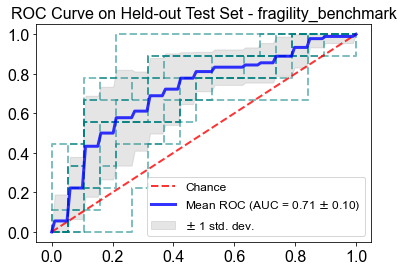

In [40]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set - {exp_name}",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(figure_dir / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")

## Plotting Predicted Probability of Success Scores

In [62]:
# TODO: modify to fit the participants framework
y_probas = []
subj_list = []
exp_conditions = []
y_outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]

        # this should match the original
        if outcome.startswith("epilepsy"):
            y_outcome = "epilepsy"
        else:
            y_outcome = outcome
        y_outcomes.append(y_outcome)
        exp_conditions.append(outcome)

        if subject.startswith("jhh"):
            center = "JHH"
        elif subject.starstwith("jeff"):
            center = "Jefferson"
        elif subject.startswith("upmc"):
            center = "UPMC"
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [63]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, exp_conditions, y_outcomes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "exp_condition", "outcome", "center", "fold"]

display(proba_df.head())

,y_proba,subject,exp_condition,outcome,center,fold
0,0.311667,jhh205,epilepsy-abnormal-eeg,epilepsy,JHH,0
1,0.093,jhh228,epilepsy-abnormal-eeg,epilepsy,JHH,0
2,0.527317,jhh028,non-epilepsy-normal-eeg,non-epilepsy-normal-eeg,JHH,0
3,0.125333,jhh227,epilepsy-abnormal-eeg,epilepsy,JHH,0
4,0.148167,jhh011,non-epilepsy-normal-eeg,non-epilepsy-normal-eeg,JHH,0


[Text(0, 0.5, 'Predicted Probability of Epilepsy'),
 Text(0.5, 0, 'Experimental Condition')]

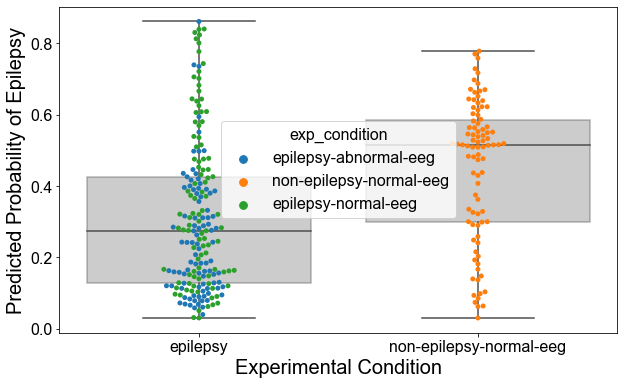

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba",
    hue="exp_condition",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Experimental Condition",
)
# fig.savefig(figure_dir / f"{exp_name}_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight")

## Boundary Split Figure

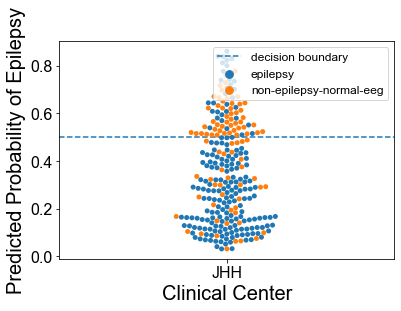

In [112]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline([0.5], ls="--", label="decision boundary")
# sns.boxplot(
#     x="center",
#     y="y_proba",
#     data=proba_df,
#     color="gray",
#     ax=ax,
#     boxprops=dict(alpha=0.4),
# )
sns.swarmplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Clinical Center",
)
ax.legend(fontsize=12)
# fig.savefig(figure_dir / f"{exp_name}_boundary_split_center.pdf", bbox_inches="tight")

## Plotting Calibration Curve

In [67]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

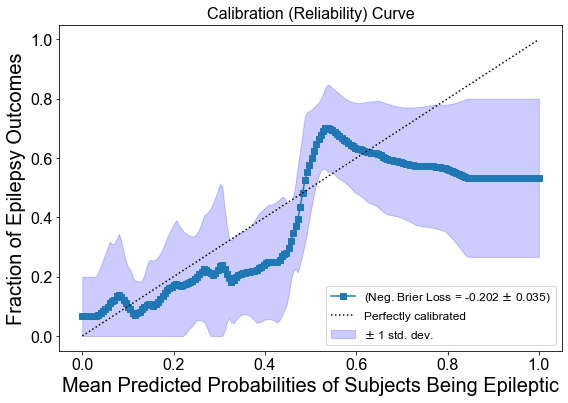

In [68]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Epilepsy Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Probabilities of Subjects Being Epileptic",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)

# fig.savefig(figure_dir / f"{exp_name}_calibration_curve.pdf", bbox_inches="tight")

# Look at Feature Importances

In [69]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity'])


In [82]:
importances = scores["test_importances"]
print(len(importances))
print([np.array(x).shape for x in importances])

10
[(32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5)]


done


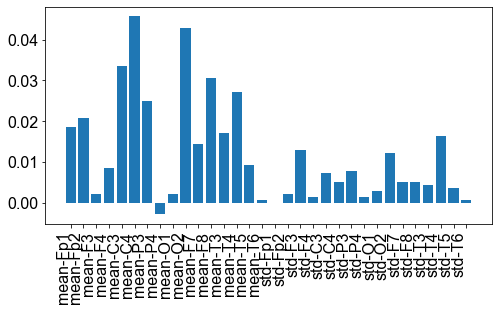

In [110]:
mean_imp = np.array([np.mean(x, axis=1) for x in importances]).mean(axis=0)
std_imp = np.array([np.std(x, axis=1) for x in importances]).mean(axis=0)

# plt.figure()
# sns.heatmap(mean_imp, xticklabels=chr)

# plt.figure()
# sns.heatmap(std_imp)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(np.arange(len(mean_imp)), mean_imp)
ax.set(
    xticks=np.arange(len(mean_imp)),
)
ax.set_xticklabels(
    [f"mean-{ch}" for ch in ch_names] + [f"std-{ch}" for ch in ch_names],
    rotation=90,
    ha="right",
)
print("done")

# McNemars Test To Compare Two Different Classification Scenarios

In [55]:
from numpy.testing import assert_array_equal

In [56]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [57]:
y_target = []
y_modelhfo = []
y_modelss = []

y_subjs = []
for idx in range(n_splits):
    y = ss_scores["test_subjects"][idx]
    hfo_y = hfo_scores["test_subjects"][idx]

    assert_array_equal(y, hfo_y)
    y_subjs.extend(y)

    y_predhfo = hfo_scores["test_y_pred_proba"][idx]
    y_predss = ss_scores["test_y_pred_proba"][idx]
    y_modelhfo.extend(y_predhfo)
    y_modelss.extend(y_predss)

In [58]:
for subject in y_subjs:
    outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
    y_target.append(outcome)

y_target = enc.fit_transform(np.array(y_target)[:, np.newaxis]).squeeze()
y_modelss = np.array(y_modelss).round()
y_modelhfo = np.array(y_modelhfo).round()

In [59]:
tb = mcnemar_table(y_target=y_target, y_model1=y_modelss, y_model2=y_modelhfo)
print(tb)

[[98 60]
 [33  9]]


In [60]:
chi2, p = mcnemar(ary=tb, corrected=True)
print("chi-squared:", chi2)
print("p-value:", p)

chi-squared: 7.268817204301075
p-value: 0.0070161992342396284


# Plots Comparing HFO and Source Sink

In [59]:
which_set = "test"

aucs = []
precisions = []
recalls = []
specificities = []
accuracies = []
clfs = []

for clf in ["HFO", "Source-Sink"]:
    if clf == "HFO":
        scores = hfo_scores
    elif clf == "Source-Sink":
        scores = ss_scores

    for idx in range(n_splits):
        auc_ = scores[f"{which_set}_roc_auc"][idx]
        precision_ = scores[f"{which_set}_average_precision"][idx]
        acc = scores[f"{which_set}_balanced_accuracy"][idx]
        sens = scores[f"{which_set}_recall"][idx]
        spec = scores[f"{which_set}_specificity"][idx]

        aucs.append(auc_)
        precisions.append(precision_)
        accuracies.append(acc)
        recalls.append(sens)
        specificities.append(spec)
        clfs.append(clf)

comp_df = pd.DataFrame((aucs, precisions, accuracies, recalls, specificities, clfs)).T
comp_df.columns = [
    "AUC",
    "Average Precision",
    "Accuracy",
    "Sensitivity",
    "Specificity",
    "Feature",
]

In [60]:
display(comp_df.head())

,AUC,Average Precision,Accuracy,Sensitivity,Specificity,Feature
0,0.787879,0.821022,0.787879,0.666667,0.909091,HFO
1,0.656566,0.665096,0.575758,0.333333,0.818182,HFO
2,0.727273,0.636522,0.676768,0.444444,0.909091,HFO
3,0.555556,0.615104,0.414141,0.555556,0.272727,HFO
4,0.707071,0.748319,0.69697,0.666667,0.727273,HFO


In [61]:
df = pd.melt(
    comp_df,
    id_vars=["Feature"],
    value_name="Value",
    var_name="Metric",
)

display(df.head())

,Feature,Metric,Value
0,HFO,AUC,0.787879
1,HFO,AUC,0.656566
2,HFO,AUC,0.727273
3,HFO,AUC,0.555556
4,HFO,AUC,0.707071


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


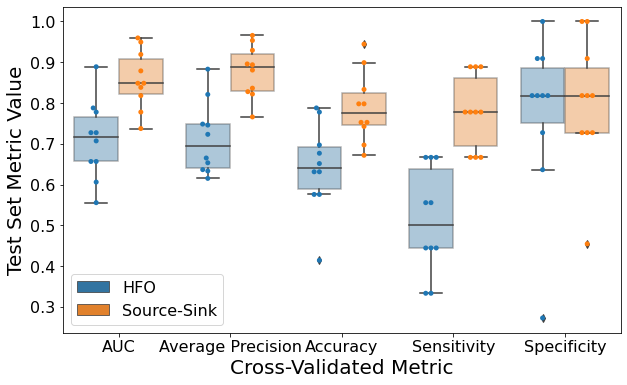

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="Metric", y="Value", hue="Feature", data=df, ax=ax, boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="Metric", y="Value", hue="Feature", data=df, ax=ax, split=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(
    xlabel="Cross-Validated Metric",
    ylabel="Test Set Metric Value",
)
fig.savefig(figure_dir / "compare_metrics.pdf", bbox_inches="tight")